# Propagation of Asymmetric waveguide

We think their definitions of radiation mode classes might not diagonalize the integral coefficient system in the case of non-symmetric waveguides.  Here we check.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from slab import SlabExact
from fiberamp.fiber.microstruct.bragg import plotlogf, plotlogf_real
from scipy.optimize import newton
from scipy.integrate import quad
plt.style.use('dark_background')
%matplotlib widget

In [2]:
A = SlabExact(scale=1e-6, ts=[4e-6, 2e-6, 2e-6, 4e-6],
              ns=[1.47, 1.5, 1.8, 1.47], xrefs=[400, 200, 200, 400],
              symmetric=True)

## Check orthogonality of classes

In [3]:
# Set betas, types of radiation modes (via sign), find vectors v and w for both, and transmission matrices

beta_check = .8 * A.K_low

C1 = A.coefficients(beta_check, mode_type='radiation', sign='+1', paper_method=False)
C2 = A.coefficients(beta_check, mode_type='radiation', sign='-1', paper_method=False)

v1, w1 = C1.T[0], C1.T[-1]
v2, w2 = C2.T[0], C2.T[-1]

S = np.array([[0,1],[1,0]]) 

v2.T @ S @ v1 + w2.T @ S @ w1

(-7.153999614928352e-14+0j)

In [4]:
S = np.array([[0,1],[1,0]]) 

def orthogonality(Z):
    
    C1 = A.coefficients(Z, mode_type='radiation', sign='+1', Z_plane=True).transpose(0,2,1)
    C2 = A.coefficients(Z, mode_type='radiation', sign='-1', Z_plane=True).transpose(0,2,1)
    
    v1, w1 = C1[...,0,:][:,:,np.newaxis], C1[...,-1,:][:,:,np.newaxis]
    v2, w2 = C2[...,0,:][:,:,np.newaxis], C2[...,-1,:][:,:,np.newaxis]
    
    return (v2.transpose(0,2,1) @ S @ v1 + w2.transpose(0,2,1) @ S @ w1)[:,0,0]

In [5]:
Zs = np.linspace(0.001, 20, 2000)
ys = orthogonality(Zs)


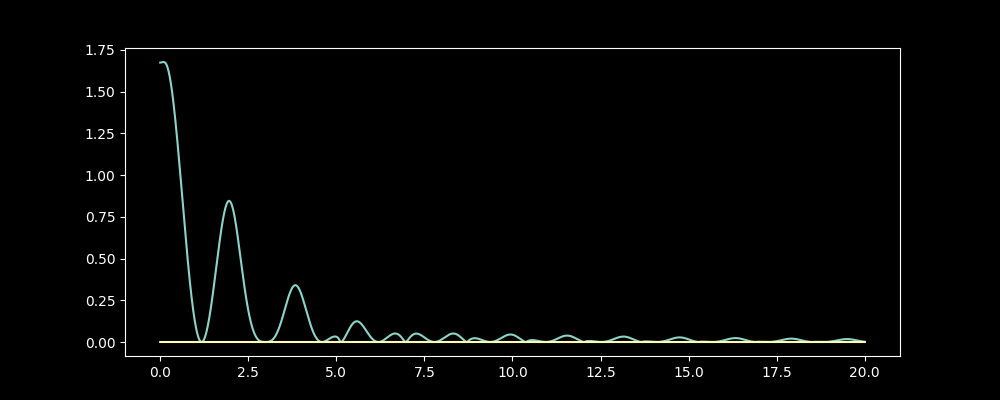

In [6]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(10,4))
ax.plot(Zs, np.abs(ys.real));
ax.plot(Zs, ys.imag);

# Define input functions

In [7]:
b = 1.25
a = 1/ b**2

def quadratic_piecewise(x):
    conds = [(x<-b), ((-b<=x)*(x<=b)), (x>b)]
    funcs = [0, lambda x: 1 - a * x**2, 0]
    return .1*np.piecewise(x, conds, funcs)
    
def modified_dist(x):
    return (x-1/4) * np.exp(-((x-1/2)/.5)**2)  

def odd_modified_dist(x):
    return x * np.exp(-x**2)
    
def normal_dist(x):
    return np.exp(-x**2)

In [8]:
# Set input function
f0 = quadratic_piecewise

# Just to plot
f0_shifted = lambda x: f0(x) + 1.47

# Set input field type
field_type = 'TE'

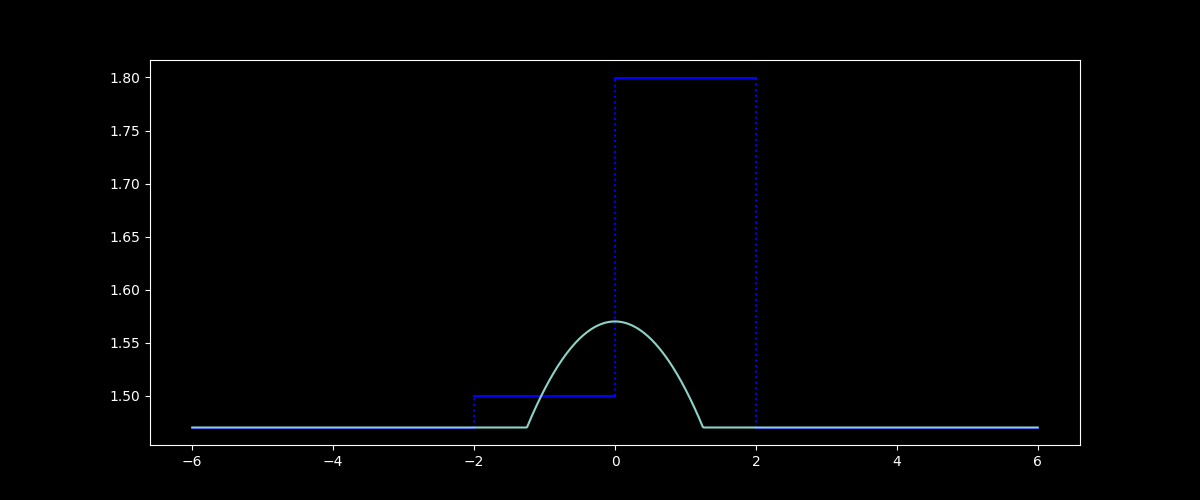

In [9]:
A.plot_refractive_index();
A.add_1d_plot(plt.gca(), f0_shifted)

# Add Guided Portion

Based on info below, we found the actual guided mode near K_low

In [10]:
mode_type = 'guided'
k_low = A.K_low

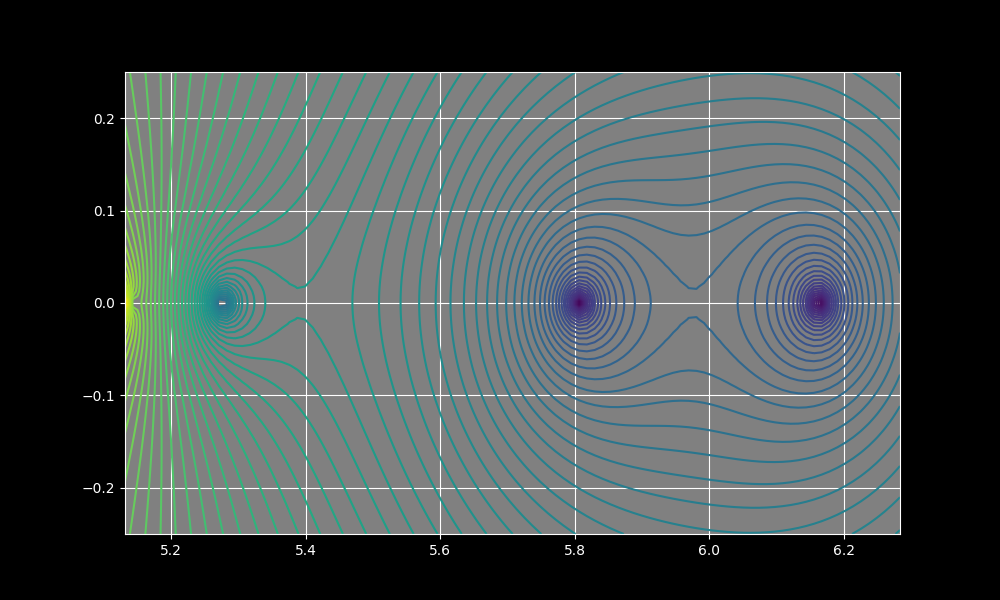

In [11]:
plotlogf(A.determinant, A.K_low, 1.0001*A.K_high, -.25, .25, field_type, mode_type,
         iref=100, rref=100,levels=100, figsize=(10,6), colorbar=False)

There is another guided mode near K_low:

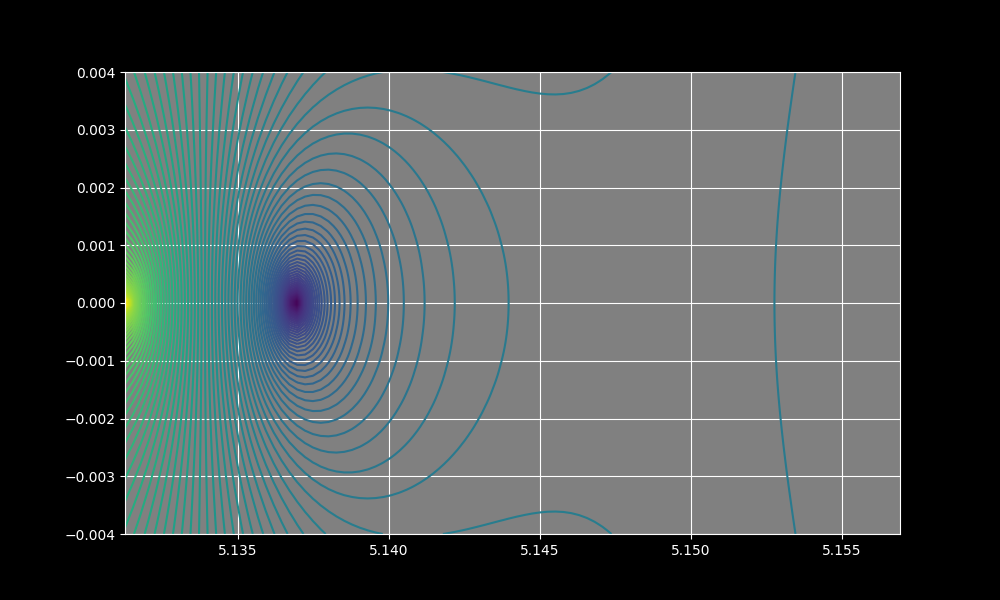

In [12]:
plotlogf(A.determinant, A.K_low, 1.005*A.K_low, -.004, .004, field_type, mode_type,
         iref=100, rref=100,levels=100, figsize=(10,6), colorbar=False)

In [13]:
beta_g1 = newton(A.determinant, 6.25, args=(field_type, mode_type))
beta_g2 = newton(A.determinant, 5.8, args=(field_type, mode_type))
beta_g3 = newton(A.determinant, 5.3, args=(field_type, mode_type))
beta_g4 = newton(A.determinant, 5.135, args=(field_type, mode_type))

beta_g1, beta_g2, beta_g3, beta_g4

((6.163640396025465-2.3464879664203618e-17j),
 (5.8072064345251855-1.6348106746555312e-17j),
 (5.275876070711505-1.5807768797380372e-17j),
 (5.136878905434453+9.977911712531317e-19j))

In [14]:
Fg1 = A.fields(beta_g1, field_type=field_type, mode_type=mode_type, c0=1)
Fg2 = A.fields(beta_g2, field_type=field_type, mode_type=mode_type, c0=-1)
Fg3 = A.fields(beta_g3, field_type=field_type, mode_type=mode_type, c0=-1)
Fg4 = A.fields(beta_g4, field_type=field_type, mode_type=mode_type, c0=-1)

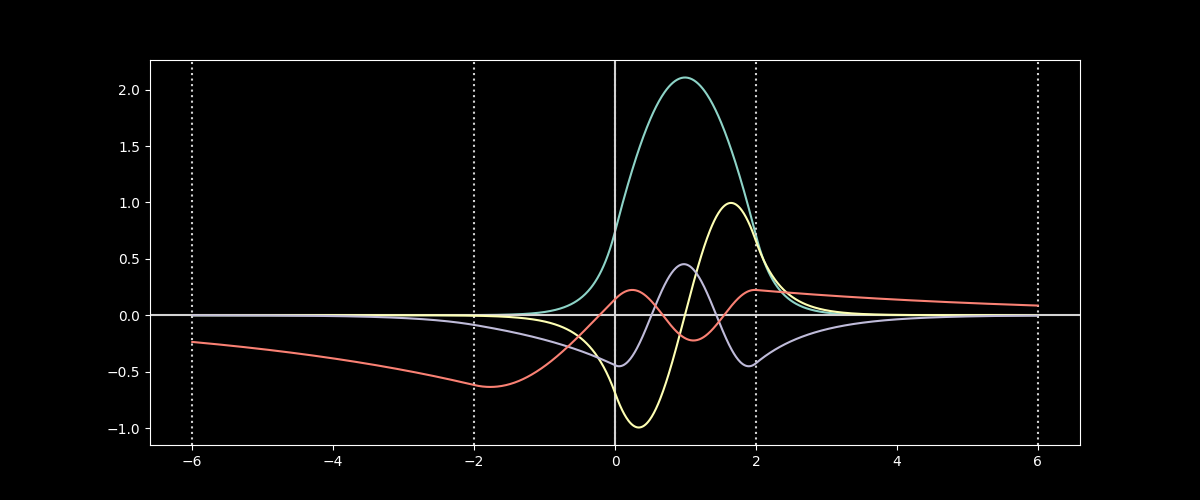

In [15]:
A.plot_field_1d(Fg1)
A.add_1d_plot(plt.gca(), Fg2)
A.add_1d_plot(plt.gca(), Fg3)
A.add_1d_plot(plt.gca(), Fg4)

### Guided coefficients

In [16]:
integrand = lambda x: Fg1(x) * Fg1(x).conjugate()
cf1 = quad(integrand, -6, 6, complex_func=True)[0]

integrand = lambda x: f0(x) * Fg1(x).conjugate()
cf2 = quad(integrand, -2,2, complex_func=True)[0]

alpha1 = cf2/cf1
alpha1

(0.026200919767050294-4.84913750135523e-19j)

In [17]:
integrand = lambda x: Fg2(x) * Fg2(x).conjugate()
cf1 = quad(integrand, -6, 6, complex_func=True)[0]

integrand = lambda x: f0(x) * Fg2(x).conjugate()
cf2 = quad(integrand, -2,2, complex_func=True)[0]

alpha2 = cf2/cf1
alpha2

(-0.06062662660052218+1.7657626908664185e-19j)

In [18]:
integrand = lambda x: Fg3(x) * Fg3(x).conjugate()
cf1 = quad(integrand, -6, 6, complex_func=True)[0]

integrand = lambda x: f0(x) * Fg3(x).conjugate()
cf2 = quad(integrand, -2,2, complex_func=True)[0]

alpha3 = cf2/cf1
alpha3

(-0.07670636263643006+3.739260543354856e-18j)

In [19]:
integrand = lambda x: Fg4(x) * Fg4(x).conjugate()
cf1 = quad(integrand, -30, 30, complex_func=True)[0]

integrand = lambda x: f0(x) * Fg4(x).conjugate()
cf2 = quad(integrand, -2,2, complex_func=True)[0]

alpha4 = cf2/cf1
alpha4

(-0.0037021544490228246+0j)

# Visualize Guided Portion

In [20]:
guided = lambda x: alpha1 * Fg1(x) + alpha2 * Fg2(x) + alpha3*Fg3(x) + alpha4 * Fg4(x)
Guided = lambda x,z : alpha1 * Fg1(x,z) + alpha2 * Fg2(x,z) + alpha3 * Fg3(x,z) + alpha4 * Fg4(x,z)


In [28]:
xs = np.linspace(-12,12,500)

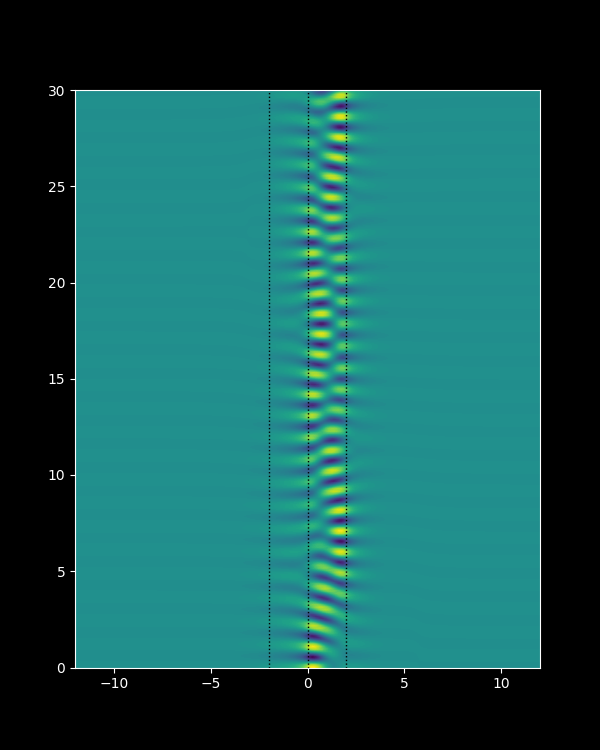

In [30]:
A.plot_field_2d(Guided, xs=xs, zmin=0, zmax=30, zref=250, colorbar=False, figwidth=6)


# Propagate Radiation Field

In [31]:
A.Z_hyperbolic, A.Z_evanescent.real

(0.0, 5.1312680008633285)

In [32]:
Propagator_Class = A.propagator()

In [48]:
P0e = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=0.0001, RZ=1.2, NZ=50, 
                     field_type=field_type, 
                     paper_method=False, sign='+1')

 92% (46 of 50) |######################  | Elapsed Time: 0:00:00 ETA:   0:00:00

In [49]:
P0o = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=0.0001, RZ=1.2, NZ=50, 
                     field_type=field_type, 
                     paper_method=False, sign='-1')

 96% (48 of 50) |####################### | Elapsed Time: 0:00:00 ETA:   0:00:00

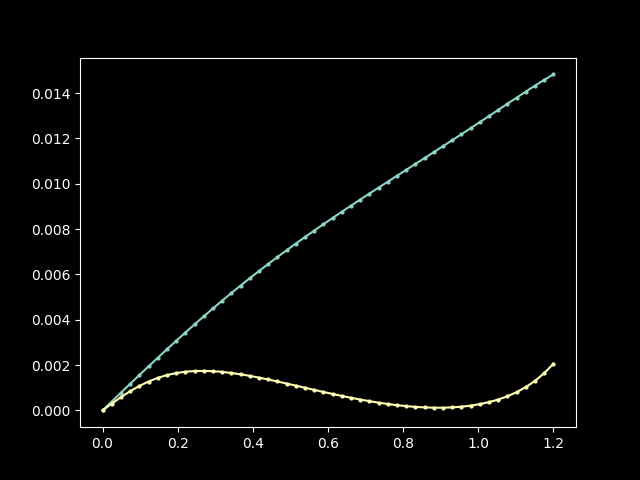

In [50]:
plt.close('all')
plt.plot(P0e.Zs, P0e.alphas.real, marker='o', markersize=2)
plt.plot(P0o.Zs, P0o.alphas.real, marker='o', markersize=2)

In [67]:
P1e = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=1.2, RZ=1.7, NZ=100, 
                     field_type=field_type, 
                     paper_method=False, sign='+1')

 97% (97 of 100) |###################### | Elapsed Time: 0:00:01 ETA:   0:00:00

In [68]:
P1o = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=1.2, RZ=1.7, NZ=100, 
                     field_type=field_type, 
                     paper_method=False, sign='-1')

 97% (97 of 100) |###################### | Elapsed Time: 0:00:01 ETA:   0:00:00

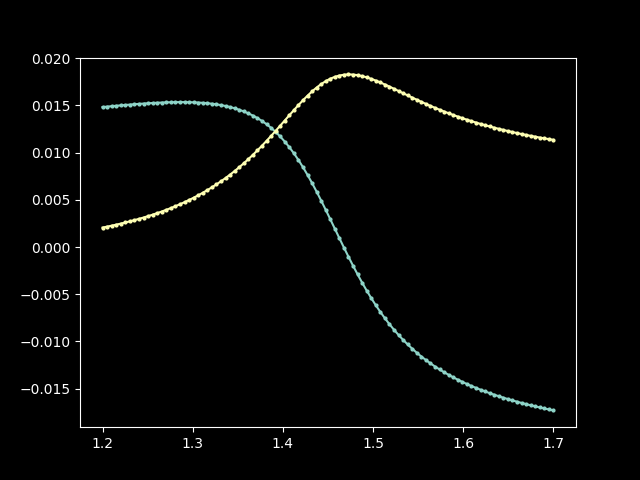

In [69]:
plt.close('all')
plt.plot(P1e.Zs, P1e.alphas.real, marker='o', markersize=2)
plt.plot(P1o.Zs, P1o.alphas.real, marker='o', markersize=2)

In [62]:
P1_5e = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=1.7, RZ=A.Z_evanescent.real, NZ=100, 
                     field_type=field_type, 
                     paper_method=False, sign='+1')

 97% (97 of 100) |###################### | Elapsed Time: 0:00:01 ETA:   0:00:00

In [65]:
P1_5o = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=1.7, RZ=A.Z_evanescent.real, NZ=100, 
                     field_type=field_type, 
                     paper_method=False, sign='-1')

 97% (97 of 100) |###################### | Elapsed Time: 0:00:01 ETA:   0:00:00

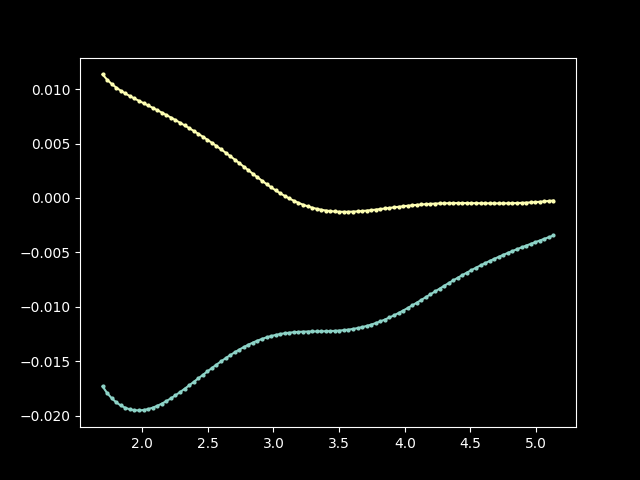

In [66]:
plt.close('all')
plt.plot(P1_5e.Zs, P1_5e.alphas.real, marker='o', markersize=2)
plt.plot(P1_5o.Zs, P1_5o.alphas.real, marker='o', markersize=2)

In [73]:
P2e = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=A.Z_evanescent.real, RZ=6, NZ=50, 
                     field_type=field_type, 
                     paper_method=False, sign='+1')

 92% (46 of 50) |######################  | Elapsed Time: 0:00:00 ETA:   0:00:00

In [74]:
P2o = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=A.Z_evanescent.real, RZ=6, NZ=50, 
                     field_type=field_type, 
                     paper_method=False, sign='-1')

 94% (47 of 50) |######################  | Elapsed Time: 0:00:00 ETA:   0:00:00

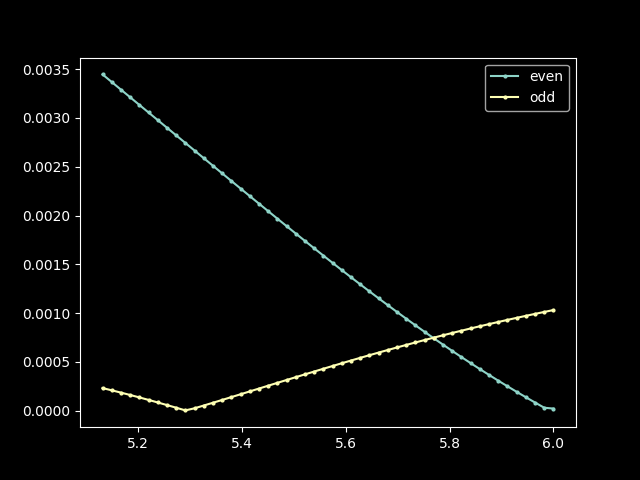

In [75]:
plt.close('all')
plt.plot(P2e.Zs, np.abs(P2e.alphas.real), marker='o', markersize=2, label='even')
plt.plot(P2o.Zs, np.abs(P2o.alphas.real), marker='o', markersize=2, label='odd')
plt.legend()

In [76]:
P3e = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=6, RZ=7.5, NZ=100,
                     field_type=field_type, 
                     paper_method=False, sign='+1')

 97% (97 of 100) |###################### | Elapsed Time: 0:00:01 ETA:   0:00:00

In [77]:
P3o = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=6, RZ=7.5, NZ=100,
                     field_type=field_type, 
                     paper_method=False, sign='-1')

 97% (97 of 100) |###################### | Elapsed Time: 0:00:01 ETA:   0:00:00

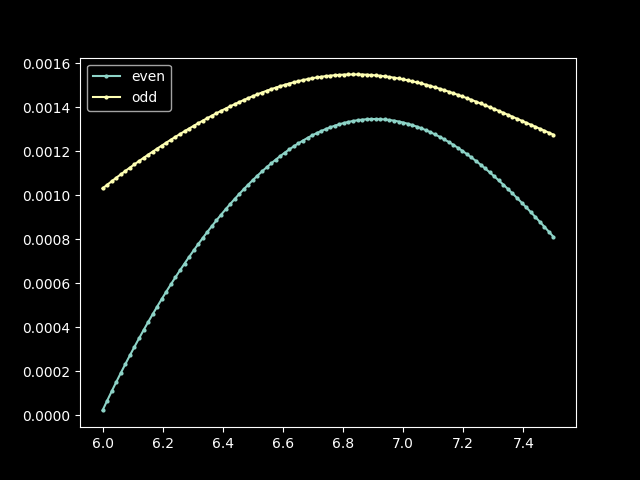

In [78]:
plt.close('all')
plt.plot(P3e.Zs, np.abs(P3e.alphas.real), marker='o', markersize=2, label='even')
plt.plot(P3o.Zs, np.abs(P3o.alphas.real), marker='o', markersize=2, label='odd')
plt.legend()

In [79]:
P4e = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=7.5, RZ=10, NZ=100,
                     field_type=field_type, 
                     paper_method=False, sign='+1')

 97% (97 of 100) |###################### | Elapsed Time: 0:00:01 ETA:   0:00:00

In [80]:
P4o = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=7.5, RZ=10, NZ=100,
                     field_type=field_type, 
                     paper_method=False, sign='-1')

 97% (97 of 100) |###################### | Elapsed Time: 0:00:01 ETA:   0:00:00

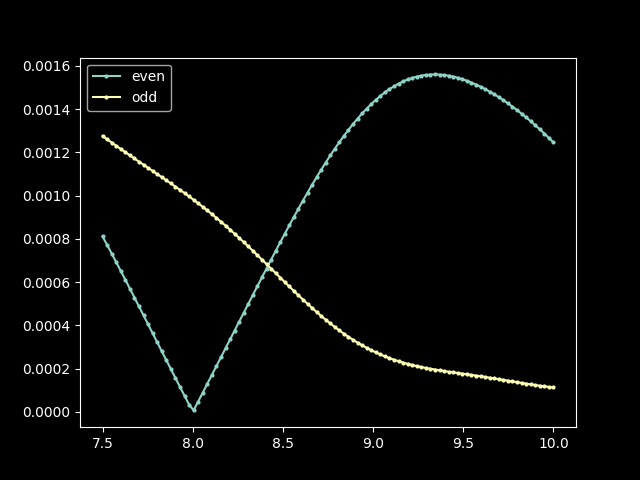

In [81]:
plt.close('all')
plt.plot(P4e.Zs, np.abs(P4e.alphas.real), marker='o', markersize=2, label='even')
plt.plot(P4o.Zs, np.abs(P4o.alphas.real), marker='o', markersize=2, label='odd')
plt.legend()

In [82]:
P5e = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=10, RZ=10.5, NZ=50,
                     field_type=field_type, 
                     paper_method=False, sign='+1')

 94% (47 of 50) |######################  | Elapsed Time: 0:00:00 ETA:   0:00:00

In [83]:
P5o = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=10, RZ=10.5, NZ=50,
                     field_type=field_type, 
                     paper_method=False, sign='-1')

 94% (47 of 50) |######################  | Elapsed Time: 0:00:00 ETA:   0:00:00

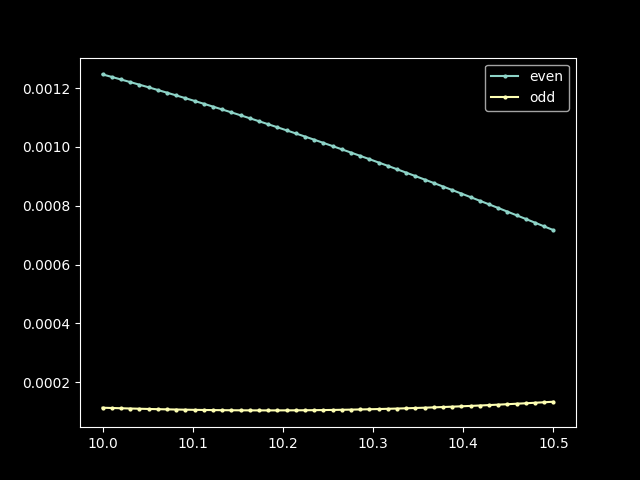

In [84]:
plt.close('all')
plt.plot(P5e.Zs, np.abs(P5e.alphas.real), marker='o', markersize=2, label='even')
plt.plot(P5o.Zs, np.abs(P5o.alphas.real), marker='o', markersize=2, label='odd')
plt.legend()

In [85]:
P6e = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=10.5, RZ=12.5, NZ=100,
                     field_type=field_type, 
                     paper_method=False, sign='+1')

 99% (99 of 100) |###################### | Elapsed Time: 0:00:01 ETA:   0:00:00

In [90]:
P6o = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=10.5, RZ=12.5, NZ=70,
                     field_type=field_type, 
                     paper_method=False, sign='-1')

 98% (69 of 70) |####################### | Elapsed Time: 0:00:01 ETA:   0:00:00

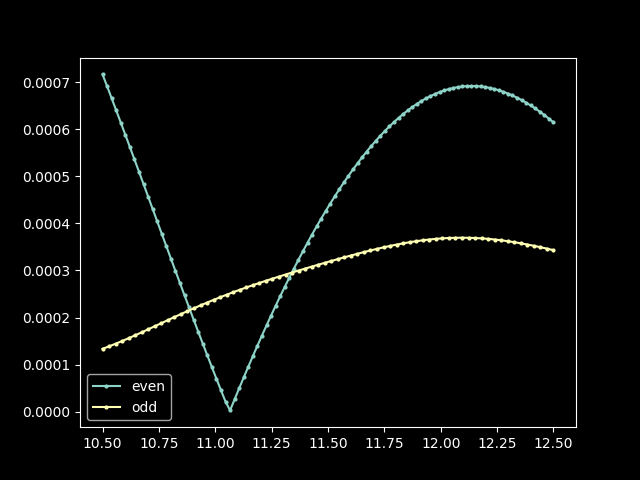

In [91]:
plt.close('all')
plt.plot(P6e.Zs, np.abs(P6e.alphas.real), marker='o', markersize=2, label='even')
plt.plot(P6o.Zs, np.abs(P6o.alphas.real), marker='o', markersize=2, label='odd')
plt.legend()

In [94]:
P7e = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=12.5, RZ=20, NZ=200,
                     field_type=field_type, 
                     paper_method=False, sign='+1')

 99% (198 of 200) |##################### | Elapsed Time: 0:00:05 ETA:   0:00:00

In [92]:
P7o = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=12.5, RZ=20, NZ=100,
                     field_type=field_type, 
                     paper_method=False, sign='-1')

 99% (99 of 100) |###################### | Elapsed Time: 0:00:02 ETA:   0:00:00

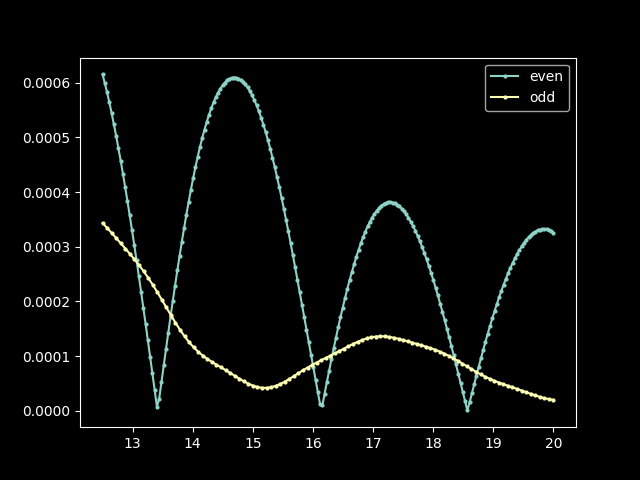

In [95]:
plt.close('all')
plt.plot(P7e.Zs, np.abs(P7e.alphas.real), marker='o', markersize=2, label='even')
plt.plot(P7o.Zs, np.abs(P7o.alphas.real), marker='o', markersize=2, label='odd')
plt.legend()

In [104]:
P8e = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=20, RZ=40, NZ=200,
                     field_type=field_type, 
                     paper_method=False, sign='+1')

 99% (198 of 200) |##################### | Elapsed Time: 0:00:09 ETA:   0:00:00

In [101]:
P8o = Propagator_Class(f0=f0, Lx=-1.25, Rx=1.25, 
                     LZ=20, RZ=40, NZ=100,
                     field_type=field_type, 
                     paper_method=False, sign='-1')

 99% (99 of 100) |###################### | Elapsed Time: 0:00:04 ETA:   0:00:00

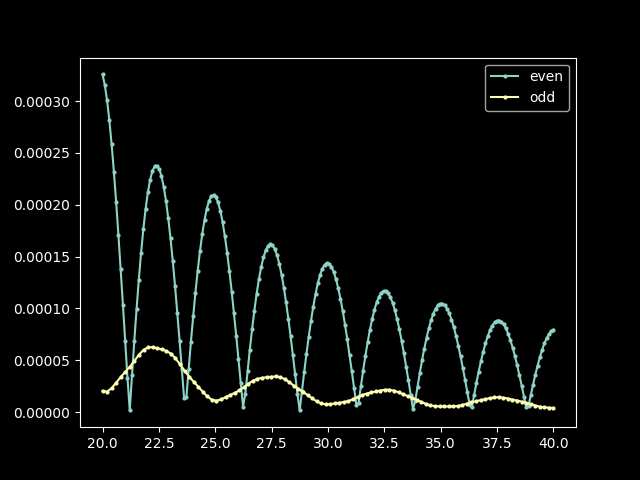

In [105]:
plt.close('all')
plt.plot(P8e.Zs, np.abs(P8e.alphas.real), marker='o', markersize=2, label='even')
plt.plot(P8o.Zs, np.abs(P8o.alphas.real), marker='o', markersize=2, label='odd')
plt.legend()

### Combine propagators into one function

In [136]:
Pse = [P0e, P1e, P1_5e, P2e, P3e, P4e, P5e, P6e, P7e, P8e]
Pso = [P0o, P1o, P1_5o, P2o, P3o, P4o, P5o, P6o, P7o, P8o]
Ps = Pse + Pso
portion = 'propagating'

full = lambda x: sum([P.slice_propagate(x, portion=portion) for P in Ps]) + alpha1 * Fg1(x) + alpha2 * Fg2(x) + alpha3*Fg3(x) + alpha4 * Fg4(x)
Full = lambda x, z : sum([P.propagate(x, zs=z, portion=portion) for P in Ps]) + alpha1 * Fg1(x,z) + alpha2 * Fg2(x,z)+ alpha3*Fg3(x, z) + alpha4*Fg4(x, z)

rad = lambda x: sum([P.slice_propagate(x, portion=portion) for P in Ps]) 
Rad = lambda x, z : sum([P.propagate(x, zs=z, portion=portion) for P in Ps])

diff = lambda x: full(x) - f0(x)

## 1D Plots

In [137]:
xs = np.linspace(-6,6,2000)

### Full field

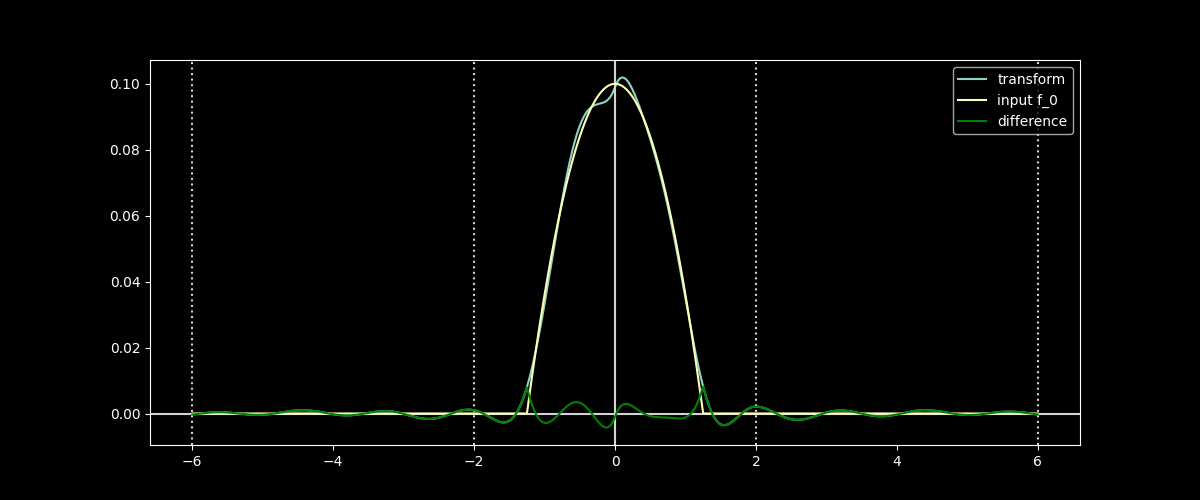

In [138]:
A.plot_field_1d(full, xs=xs, part='real', label='transform');
A.add_1d_plot(plt.gca(), f0, xs=xs, label='input f_0')
A.add_1d_plot(plt.gca(), diff, xs=xs, color='g', label='difference')
plt.legend()

### Radiation Field

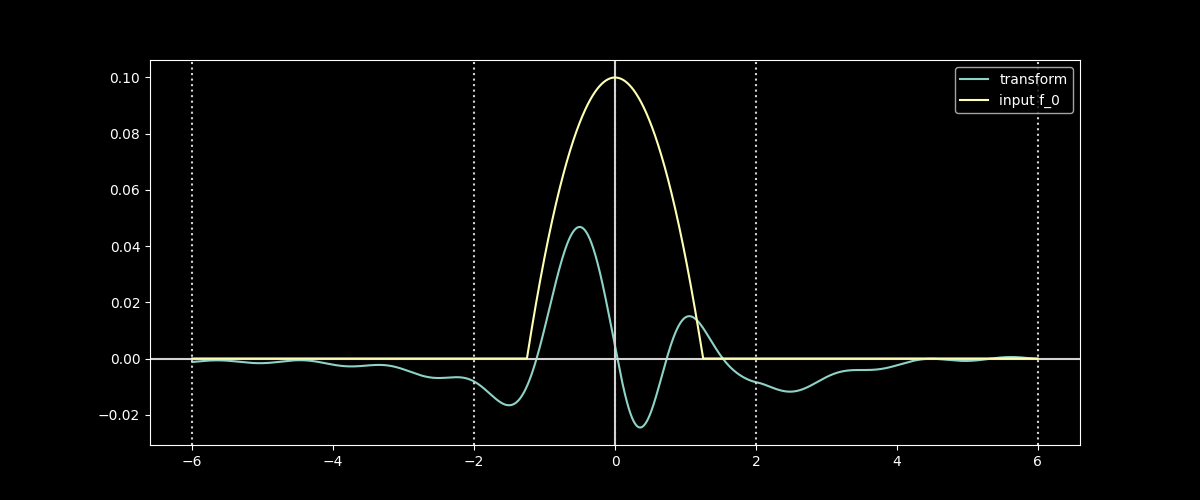

In [139]:
A.plot_field_1d(rad, xs=xs, part='real', label='transform');
A.add_1d_plot(plt.gca(), f0, xs=xs, label='input f_0')

plt.legend()

# 2D Plots

In [109]:
xs = np.linspace(-10, 10, 500)

### Full field

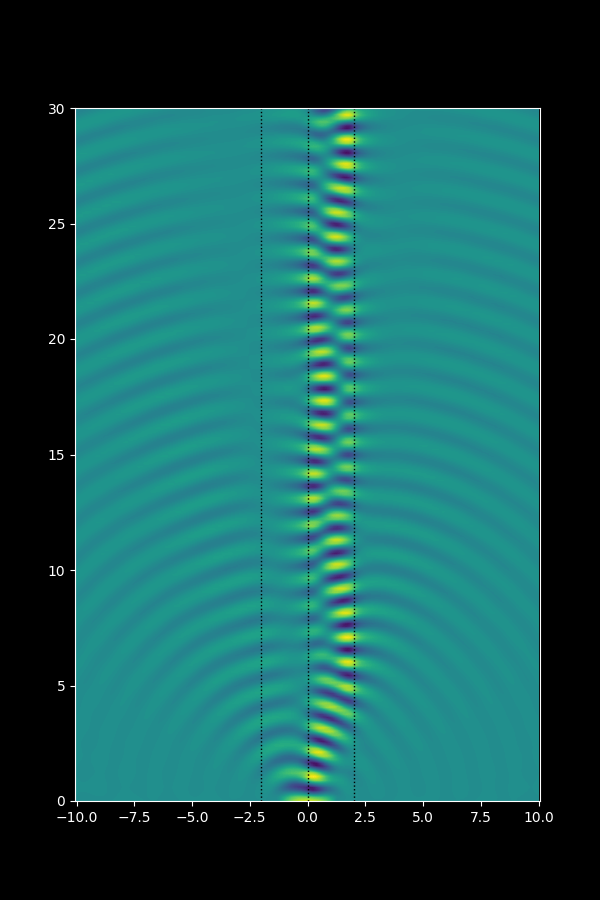

In [113]:
A.plot_field_2d(Full, xs=xs, zmin=0, zmax=30, zref=200, colorbar=False, figwidth=6)
plt.axis('equal');

### Radiation field

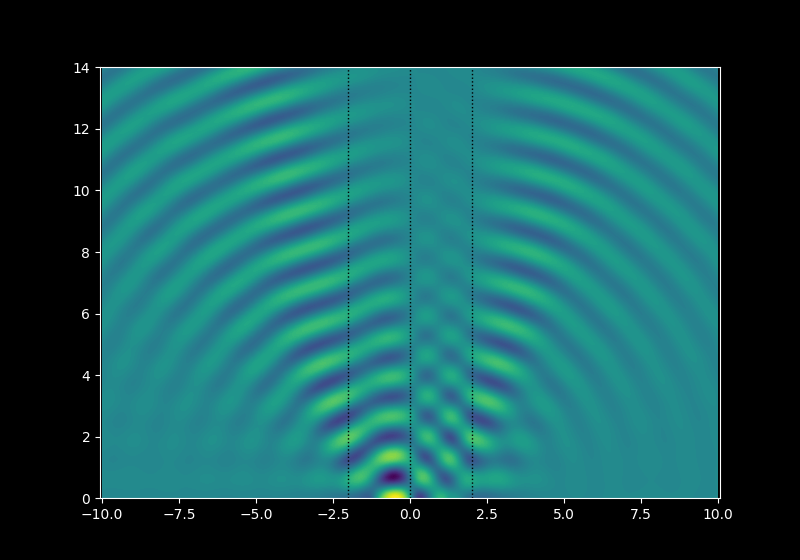

In [116]:
A.plot_field_2d(Rad, xs=xs, zmin=0, zmax=14, zref=300, colorbar=False, figwidth=8)
plt.axis('equal');

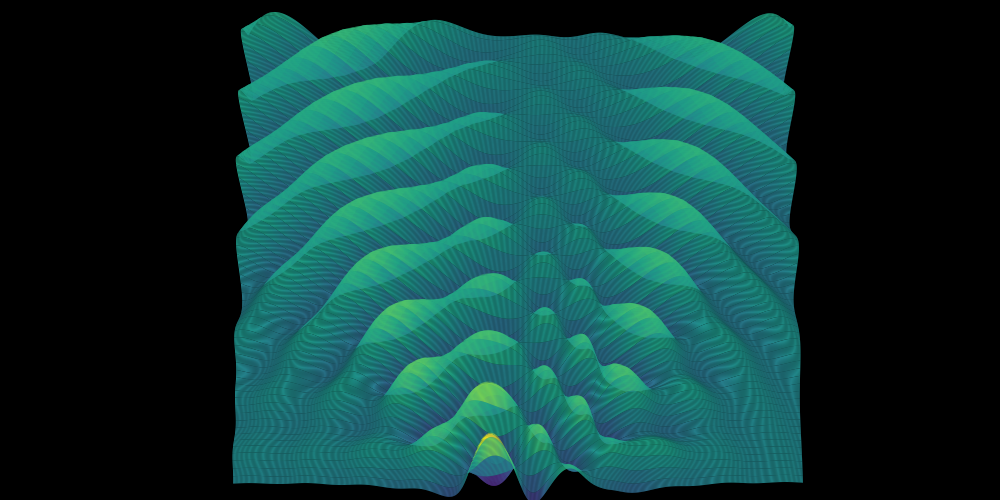

In [140]:
A.plot_field_2d(Rad, surface=True, xs=xs, colorbar=False, zoom=2.5,
                azim=-90, elev=75, 
                zmax=10, zref=200,
                rstride=3, cstride=3)

# Get leaky modes

In [118]:
mode_type = 'leaky'
k_low = A.K_low

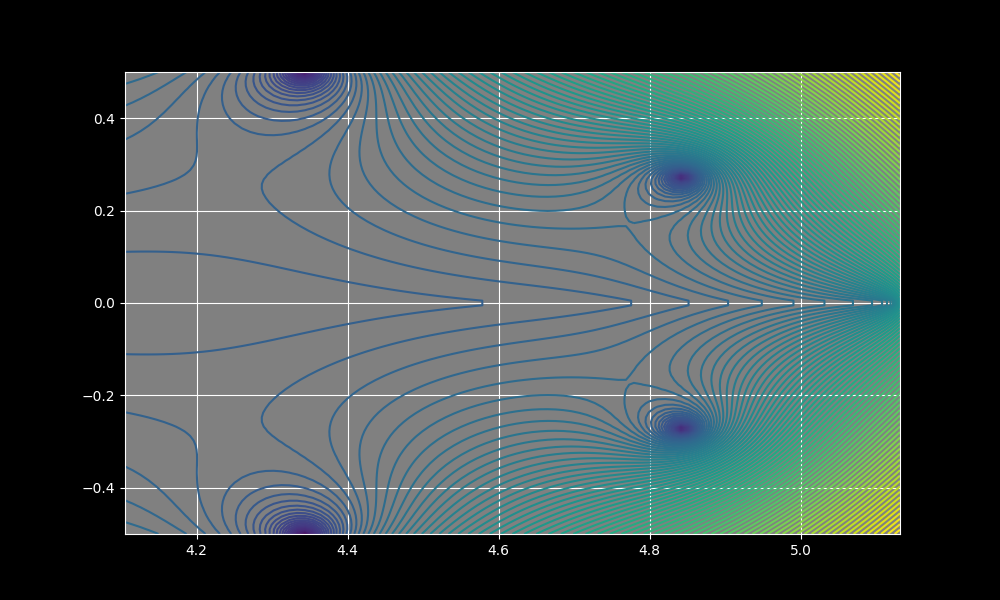

In [119]:
plt.close('all')
plotlogf(A.determinant, .8* A.K_low, 1.0001*A.K_low, -.5, .5, field_type, mode_type,
         iref=100, rref=100,levels=100, figsize=(10,6), colorbar=False)

At this wavelength, there don't appear to be any useful leaky modes.

In [141]:
beta_l1 = newton(A.determinant, np.array([4.85 +.3j]), args=(field_type, mode_type))[0]
beta_l2 = newton(A.determinant, np.array([4.38 +.4j]), args=(field_type, mode_type))[0]

beta_l1, beta_l2

((4.8439364505572255+0.27241241594834487j),
 (4.342272485801076+0.5042416719734747j))

In [142]:
Fl1 = A.fields(beta_l1, field_type=field_type, mode_type=mode_type, c0=1)
Fl2 = A.fields(beta_l2, field_type=field_type, mode_type=mode_type, c0=-1)

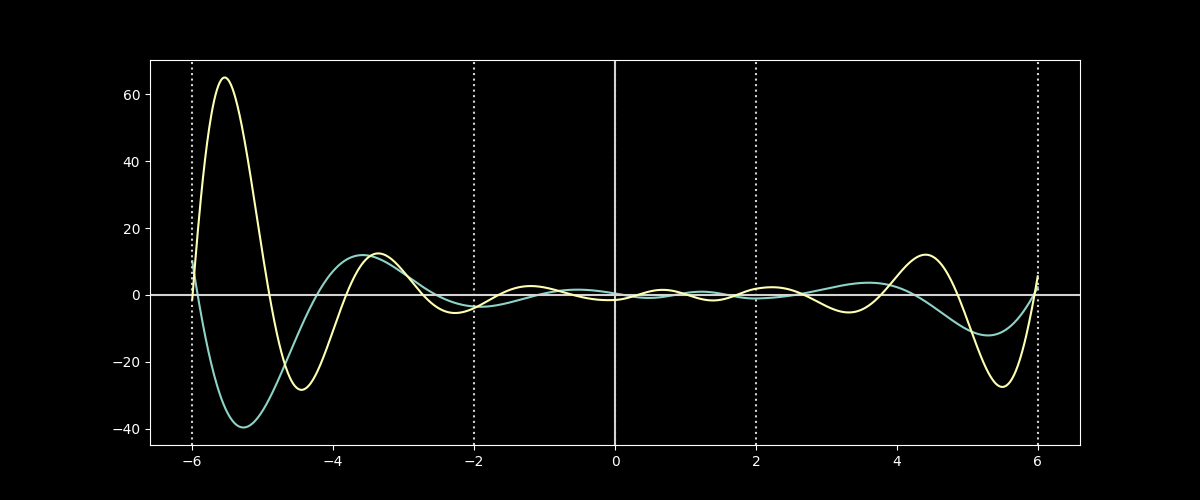

In [143]:
A.plot_field_1d(Fl1)
A.add_1d_plot(plt.gca(), Fl2)

# Save data for visualization


In [309]:
xs = A.all_Xs
zs = np.linspace(0, 100, int(100*40/2))

In [310]:
f0s = f0(xs)

In [311]:
rad_ys_propagating = Prop(xs, zs)


NameError: name 'Prop' is not defined

In [507]:
rad_ys_evanescent = Ev(xs, zs)


In [508]:
# guided_ys = alpha * Fs1(xs, zs=zs)

In [509]:
Xs, Zs = np.meshgrid(xs, zs)

In [510]:
def get_trig_indices(mesh_array):
    '''Get triangle index list for three js mesh formation via indexed buffer geometry.'''
    if len(mesh_array.shape) <= 1:
        raise ValueError('Provide meshgrid array as input.')
    Nz, Nx = mesh_array.shape[0], mesh_array.shape[1]
    l_inds = Nx * Nz
    indices =  np.arange(0, l_inds).reshape((Nx, Nz)).T  # Note transpose
    fbases = indices[:Nz-1, :Nx-1].T.flatten()  # Note transpose and index switch due to transpose
    f1 = np.array([[i, i+Nz, i+1] for i in fbases], dtype=int)
    f2 = np.array([[i+1, i+Nz, i+Nz+1] for i in fbases], dtype=int)
    return np.concatenate((f1, f2))


def get_base_vertices(Xs, Zs):
    '''Get vertices of triangles with zero height (y component in three.js).'''
    if Xs.shape != Zs.shape:
        raise ValueError('Provide meshgrid arrays (ie Xs, Zs = np.meshgrid(xs,zs)) as inputs.')
    Base = np.array([Xs, np.zeros_like(Xs), Zs], dtype=float)
    L = Xs.shape[0] * Xs.shape[1]
    base_vertices = Base.T.reshape((L,3))
    return base_vertices


def create_height_array_from_complex(ys, Xs):
    '''Get data for height from complex ys input (needs to be formatted as list:
        [ys[0].real, ys[0].imag, ys[1].real, ys[1].imag, ... ].'''
    L = Xs.shape[0] * Xs.shape[1]
    Ys = np.array([ys.real, ys.imag], dtype=float)
    heights = Ys.T.reshape((L,2))
    return heights


def save_trig_indices_as_json(filepath, mesh_array):
    indices = get_trig_indices(mesh_array)
    with open(filepath + '.json', 'w') as outfile:
        json.dump(indices.flatten().tolist(), outfile, separators=(',', ':'),
                  sort_keys=True, indent=4)


def save_base_vertices_as_json(filepath, Xs, Zs):
    base_vertices = get_base_vertices(Xs, Zs)
    with open(filepath + '.json', 'w') as outfile:
        json.dump(base_vertices.flatten().tolist(), outfile, separators=(',', ':'),
                  sort_keys=True, indent=4)
        

def save_heights_as_json(filepath, ys, Xs):
    heights= create_height_array_from_complex(ys, Xs)
    with open(filepath + '.json', 'w') as outfile:
        json.dump(heights.flatten().tolist(), outfile, separators=(',', ':'),
                  sort_keys=True, indent=4)

def save_values_as_json(filepath, f0s):
    with open(filepath + '.json', 'w') as outfile:
        json.dump(f0s.tolist(), outfile, separators=(',', ':'),
                  sort_keys=True, indent=4)


In [511]:
prefix='/home/pv/local/slab/apps/hollow_core/'

In [512]:
save_trig_indices_as_json(prefix + 'trig_indices_new', Xs)

In [513]:
save_base_vertices_as_json(prefix + 'base_vertices_new', Xs, Zs)

In [514]:
# save_heights_as_json(prefix + 'guided_heights', guided_ys, Xs)

In [515]:
save_heights_as_json(prefix + 'evanescent_heights', rad_ys_evanescent, Xs)

In [516]:
save_heights_as_json(prefix + 'propagating_heights', rad_ys_propagating, Xs)

In [517]:
save_values_as_json(prefix + 'f0s', f0s)

In [518]:
save_values_as_json(prefix + 'x0s', xs)